In [1]:
using Pkg
Pkg.activate("C:/Users/lisah/Documents/Repos/ma-code")
include("c:/Users/lisah/Documents/Repos/ma-code/src/src.jl")
using .Src

  Activating project at `C:\Users\lisah\Documents\Repos\ma-code`


# Practical Identifiability Analysis

This script tests the functionality of the code related to the practical identifiability analysis by executing some examples and different test cases.

## Notes on usage

The following fields can be set:
- `prm_keys::Vector{Symbol}`: contains the name of the parameter(s) which are treated as unknown (for example `prm_keys=[:a]`)
- `t_fixed::Bool`: true if we consider a fixed observation time window
- `t_end::Float64`: end of observation window (if `t_fixed=true`)
- `t_step::Float64`: step size with which M observations should be picked (set if `t_fixed=false`)
- `obs_late::Bool`: Set to true if we only consider observations taken in the stable state
- `t_obs::Float64`: The time at which late observations are taken if `obs_late=true`
- `hprm::Hyperprm`: all the parameters needed for model simulation of the data observations, i.e.
    - `w0`: initial value for water compartment
    - `n0`: initialvalue for biomass compartment
    - `a`: water input model parameter
    - `m`: plant mortality parameter
    - `M`: sample size (number of measurements)
    - `noise`: noise level (Gaussian variance) of the data

Returned is a tuple with the fields `mle, plot_mles,plot_losses, cor, cov, gaussian_heatmap, gaussian_surface`.
If a field is not defined in the univariate case it returns `nothing`.

## Infer single parameter

In [2]:
# determine which parameter is inferred
a_true = 1.5
prm_keys = [:a]

# further settings
t_fixed = true
hprm = Hyperprm(1.0, 1.0, a_true, 0.45, 100, 0.1)

Hyperprm(1.0, 1.0, 1.5, 0.45, 100, 0.1)

In [3]:
result_infer_a = assess_practical_identifiability(prm_keys, hprm, t_fixed=t_fixed)

(mle = [1.4980106188806745], plot_mles = Plot{Plots.GRBackend() n=6}, plot_losses = Plot{Plots.GRBackend() n=3}, cor = [1.0;;], cov = [0.0001715729955943986;;], gaussian_heatmap = nothing, gaussian_surface = Plot{Plots.GRBackend() n=1})

In [4]:
result_infer_a.mle, result_infer_a.cov

([1.4980106188806745], [0.0001715729955943986;;])

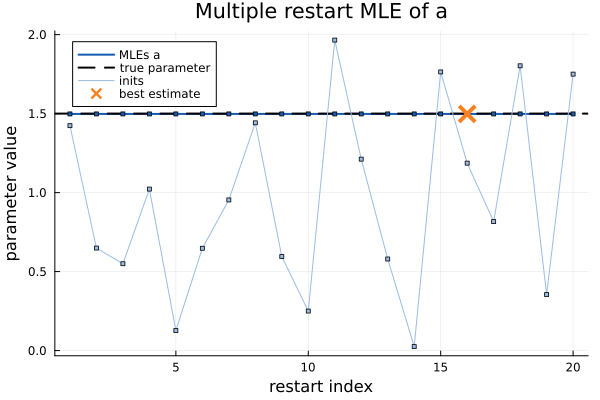

In [5]:
result_infer_a.plot_mles

## Infer two parameters

In [6]:
# determine which parameters are inferred
a_true = 1.5
m_true = 0.45
prm_keys = [:a, :m]

# further settings
t_fixed = true
hprm = Hyperprm(1.0, 1.0, a_true, m_true, 100, 0.1)

Hyperprm(1.0, 1.0, 1.5, 0.45, 100, 0.1)

In [7]:
result_infer_am = assess_practical_identifiability(prm_keys, hprm, t_fixed=t_fixed)

(mle = [1.5145100283296835, 0.4549838695576951], plot_mles = Plot{Plots.GRBackend() n=12}, plot_losses = Plot{Plots.GRBackend() n=3}, cor = [1.0 0.9976343319706171; 0.9976343319706171 1.0], cov = [0.03710424140421809 0.011299365130126377; 0.011299365130126377 0.003457337335424845], gaussian_heatmap = Plot{Plots.GRBackend() n=1}, gaussian_surface = Plot{Plots.GRBackend() n=2})

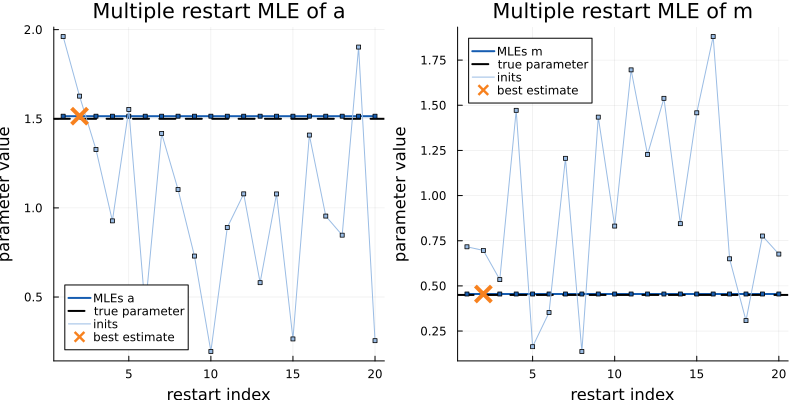

In [8]:
result_infer_am.plot_mles

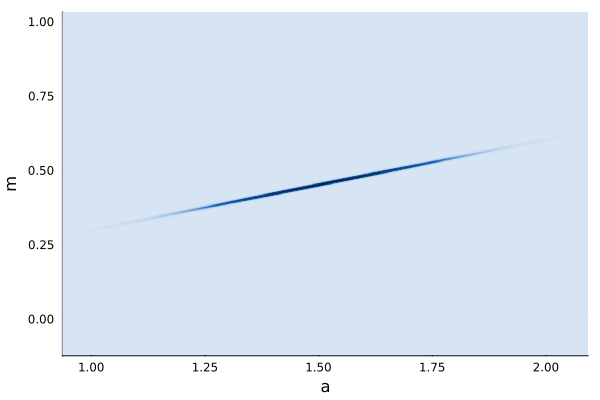

In [9]:
result_infer_am.gaussian_heatmap

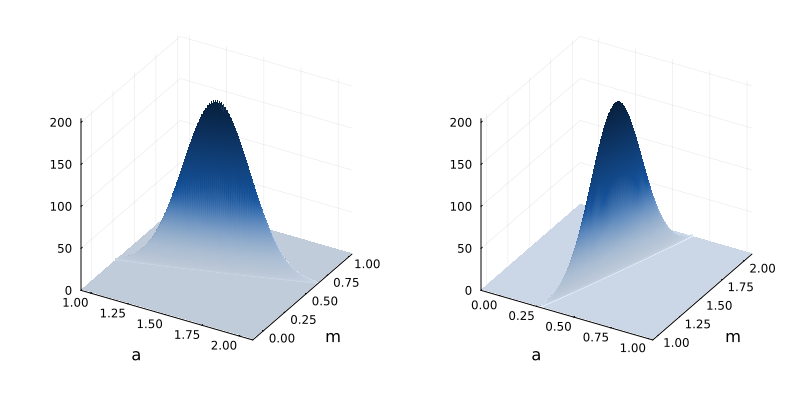

In [10]:
result_infer_am.gaussian_surface

## Infer when observing only stable state

In [11]:
# determine which parameters are inferred
a_true = 1.5
m_true = 0.45
prm_keys = [:a, :m]

# further settings
t_fixed = true
t_end = 200.0
obs_late = true
hprm = Hyperprm(1.0, 1.0, a_true, m_true, 100, 0.1)

Hyperprm(1.0, 1.0, 1.5, 0.45, 100, 0.1)

In [12]:
result_infer_late_am = assess_practical_identifiability(prm_keys, hprm, t_fixed=t_fixed, t_end=t_end, obs_late=obs_late)

(mle = [1.173742334907882, 0.35328868400540536], plot_mles = Plot{Plots.GRBackend() n=12}, plot_losses = Plot{Plots.GRBackend() n=3}, cor = [1.0 0.9995037273589786; 0.9995037273589789 1.0], cov = [0.19804308199727125 0.05947623517030313; 0.05947623517030314 0.017879625896418647], gaussian_heatmap = Plot{Plots.GRBackend() n=1}, gaussian_surface = Plot{Plots.GRBackend() n=2})

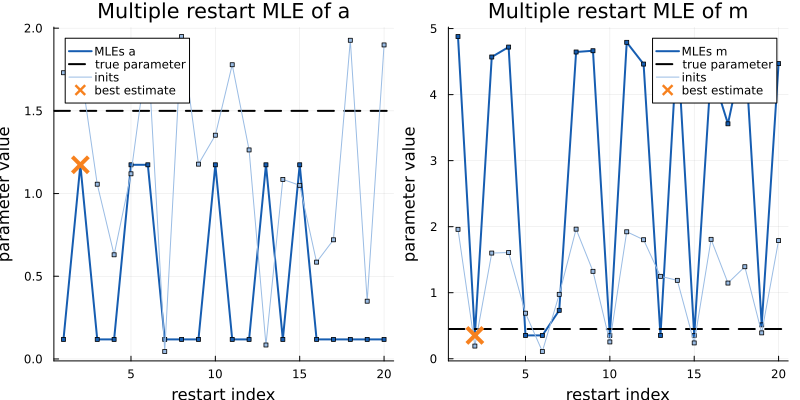

In [13]:
result_infer_late_am.plot_mles

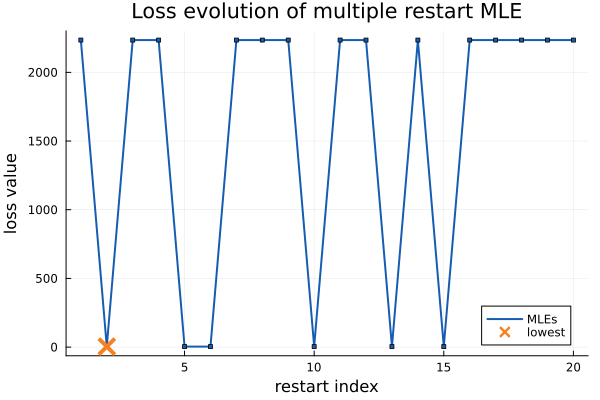

In [14]:
result_infer_late_am.plot_losses

In [15]:
result_infer_late_am.cor

2×2 Matrix{Float64}:
 1.0       0.999504
 0.999504  1.0